In [1]:
# import required packages 
import os
import cv2
import pandas as pd
import numpy as np
import glob
import math
import matplotlib.pyplot as plt

# Global Variables

In [2]:
train_img_dir = "../flower_classification/training/"
test_img_dir = "../flower_classification/testing/"
train_label_dir = "../flower_classification/training_label.csv"

# 1. Load Training Data and Testing Data

### 1.1 Define function for loading data

In [3]:
def load_training_imgs(train_imgs_dir, debug_mode=False):
    """load training images from proivided file directory
    
    Parameters
    ----------
    train_imgs_dir : str
        Relative or absolute file path for the training images
    debug_mode : boolean
        Debugging mode flag. Set to False as default. Printing intermediate results
        on the consle if set to True.
        
    Returns
    -------
    train_imgs_name : list
        a list of strings of file name without extension that corresponds to the image 
        file. Eg. [image_08108，...,image_01075]
    train_imgs : list
        a list of training images. 
    """    
    
    train_data_path = os.path.join(train_imgs_dir,'*g')
    train_files = glob.glob(train_data_path)
    train_imgs = []
    train_imgs_name = []
    
    if debug_mode:
        print("train_data_path", train_data_path)
        print("train_files length", len(train_files))
        
    for i,f1 in enumerate(train_files):
        img_name_without_extension = os.path.splitext(os.path.basename(f1))[0]
        
        if debug_mode:
            print(("image name {} without extension : {}").format(i, img_name_without_extension))        
        train_imgs_name.append(img_name_without_extension)
        
        img = cv2.imread(f1)
        train_imgs.append(img)
        
    if debug_mode:
        print("train image names length", len(train_imgs_name))
        print("train image length", len(train_imgs))
        
    return train_imgs_name, train_imgs

In [4]:
def load_testing_imgs(test_imgs_dir, debug_mode=False):
    """load testing images from proivided file directory
    
    Parameters
    ----------
    test_imgs_dir : str
        Relative or absolute file path for the testing images.
    debug_mode : boolean
        Debugging mode flag. Set to False as default. Printing intermediate results
        on the consle if set to True.
        
    Returns
    -------
    test_imgs : list
        a list of training images. 
    """    
    
    test_data_path = os.path.join(test_imgs_dir,'*g')
    test_files = glob.glob(test_data_path)
    test_imgs = []
    
    if debug_mode:
        print("test_data_path", test_data_path)
        print("test_files length", len(test_files))
        
    for i,f1 in enumerate(test_files):     
        img = cv2.imread(f1)
        test_imgs.append(img)
        
    if debug_mode:
        print("test image length", len(test_imgs))
        
    return test_imgs

In [5]:
def generate_indexed_train_labels(train_imgs_name, train_label_dir, debug_mode=False):
    """generate train labels with correct indexing corresponding to the list of training images
    
    Parameters
    ----------
    train_imgs_name : list
        List of the training images names without extension.
    train_label_dir : str
        Relative or absolute file path for the training labels csv file.
    debug_mode : boolean
        Debugging mode flag. Set to False as default. Printing intermediate results
        on the consle if set to True.
        
    Returns
    -------
    labels : list
        a list of matched train labels.
    """
    df_labels = pd.read_csv(train_label_dir)
    if debug_mode:
        print(df_labels.head())
    labels = []
    for name in train_imgs_name:
        row = df_labels.loc[df_labels['Id'] == name]
        if debug_mode:
            print("File name without extension", name)
            print(row)
        assert name == row['Id'].values[0]
        label = row['Category'].values[0]
        labels.append(label)
        
    return labels

### 1.2 Load data

In [6]:
train_imgs_names, train_imgs = load_training_imgs(train_img_dir)

In [7]:
test_imgs = load_testing_imgs(test_img_dir)

In [8]:
labels = generate_indexed_train_labels(train_imgs_names, train_label_dir)

image_07088


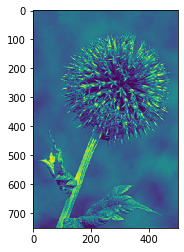

In [9]:
test_i = train_imgs[0]
test_i_rgb = cv2.cvtColor(test_i, cv2.COLOR_BGR2GRAY)
print(train_imgs_names[0])

plt.imshow(test_i_rgb)

### 1.3 Compute Size information of the training sets

In [10]:
def image_size_info(train_imgs):
    heights = [img.shape[0] for img in train_imgs]
    widths = [img.shape[1] for img in train_imgs] 
    print("Average Height: " + str(np.mean(heights)))
    print("Max Height: " + str(max(heights)))
    print("Min Height: " + str(min(heights)))
    print('\n')
    print("Average Width: " + str(np.mean(widths)))
    print("Max Width: " + str(max(widths)))
    print("Min Width: " + str(min(widths)))

In [32]:
image_size_info(train_imgs)

# For now set the size to (500, 500)
SIZE = (250, 250)

Average Height: 534.3276666666667
Max Height: 1168
Min Height: 500


Average Width: 630.6151666666667
Max Width: 1024
Min Width: 500


# 2 Pipeline Steps

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin

### 2.1 RGB2Gray Transformer Step

In [34]:
class RGB2GrayTransformer(TransformerMixin):
    """
    Convert the RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        X_transformed = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X]
        return X_transformed

### 2.2 Resizing Step

In [35]:
class ResizingTransformer(TransformerMixin):
    """
    Resize the image to a given size
    """
 
    def __init__(self, size):
        self.size = size
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        X_transformed = [cv2.resize(img, self.size) for img in X]
        return X_transformed

### 2.3 HoG Feature Extractor

In [36]:
class HoGTransformer(TransformerMixin):
    """
    Extract HoG features
    """  
    def __init__(self, img_size, cell_size=(32, 32), block_size=(2,2), nbins = 9):
        self.img_size = img_size
        self.cell_size = cell_size
        self.block_size = block_size
        self.nbins = nbins
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        hog = cv2.HOGDescriptor(_winSize=(self.img_size[1] // self.cell_size[1] * self.cell_size[1],
                                  self.img_size[0] // self.cell_size[0] * self.cell_size[0]),
                        _blockSize=(self.block_size[1] * self.cell_size[1],
                                    self.block_size[0] * self.cell_size[0]),
                        _blockStride=(self.cell_size[1], self.cell_size[0]),
                        _cellSize=(self.cell_size[1], self.cell_size[0]),
                        _nbins=self.nbins)
        
        hog_feats = [(hog.compute(img)).flatten() for img in X]    
        X_transformed = np.stack(hog_feats, axis = 0)
        
        return X_transformed

# 3. Build Pipeline

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [38]:
pipeline = Pipeline([
    ('rgb2graytransformer', RGB2GrayTransformer()),
    ('resizetransformer', ResizingTransformer(SIZE)),
    ('hogtransformer', HoGTransformer(SIZE))
])

In [39]:
X_transformed = pipeline.fit_transform(train_imgs, labels)

In [40]:
print(X_transformed.shape)

(6000, 1296)


In [65]:
param_grid = {'C': [0.01, 0.1, 1, 10]}

In [68]:
svc = SVC()
grid_search = GridSearchCV(svc, cv=5, param_grid=param_grid, verbose=10)

In [69]:
grid_search.fit(X_transformed, labels)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.032, total= 1.2min
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] .............................. C=0.01, score=0.033, total= 1.2min
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min remaining:    0.0s


[CV] .............................. C=0.01, score=0.033, total= 1.2min
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.7min remaining:    0.0s


[CV] .............................. C=0.01, score=0.033, total= 1.2min
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.9min remaining:    0.0s


[CV] .............................. C=0.01, score=0.033, total= 1.2min
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.1min remaining:    0.0s


[CV] ............................... C=0.1, score=0.068, total= 1.2min
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  7.3min remaining:    0.0s


[CV] ............................... C=0.1, score=0.068, total= 1.2min
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  8.5min remaining:    0.0s


[CV] ............................... C=0.1, score=0.066, total= 1.2min
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  9.7min remaining:    0.0s


[CV] ............................... C=0.1, score=0.070, total= 1.2min
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 11.0min remaining:    0.0s


[CV] ............................... C=0.1, score=0.068, total= 1.2min
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.277, total= 1.2min
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.258, total= 1.2min
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.244, total= 1.2min
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.268, total= 1.2min
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.264, total= 1.2min
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.314, total= 1.3min
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 25.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=10)

In [59]:
print(grid_search.cv_results_)

AttributeError: 'dict' object has no attribute 'head'